### BARTOSZ PAWLIK, MECHATRONIKA 2021/2022, 7 SEMESTR, Układy monitorowania urządzeń mechatronicznych

W projekcie zostanie przedstawione porównanie dwóch metod do time series forecasting: ARIMA oraz Prophet. Testy zostaną przeprowadzone na ogólnodostępnych danych: https://www.kaggle.com/theforcecoder/wind-power-forecasting .

Opis kolejnych kroków:
1. Eksploracja danych multivariate
2. Wybór zmiennej do prognozowania Univariate
3. Podział danych
4. Optymalizacja hiperparametrów Propheta i ARIMY
5. Test optymalnych na zbiorze testowym.

In [12]:
#wgranie koniecznych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Ustawienie standardowych parametrów wykresów. Tutaj rozmiar wykresu.
plt.rcParams['figure.figsize'] = [16, 10]

In [13]:
#Import danych wejściowych
df = pd.read_csv('Turbine_Data.csv', index_col=0)

#Ustawienie indeksu jako DateTimeIndex czyli tryb indeksu odpowiedni dla szeregów czasowych
df.index = pd.DatetimeIndex(df.index, freq='10T')
#Usunięcie strefy czasowej.
df.index = df.index.tz_convert(None)

df.head()



,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


Surowe dane mierzone są co 10 minut. Aby zmacząco zmniejszyć wymiar danych zostaną one przetworzone w ten sposób aby co godzine wyciągana była średnia z 6 pomiarów.

In [14]:
df = df.resample('D').mean()

df.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,190.815478,26.482296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.404152,34.208005,NaN,NaN,282.404152,3.866226
2018-01-02,339.470285,25.643416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.071620,66.334585,NaN,NaN,273.071620,4.677844
2018-01-03,317.517653,25.570710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.263574,61.110240,NaN,NaN,275.263574,4.520639
2018-01-04,361.856700,24.961632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.338759,72.514896,NaN,NaN,284.338759,5.063196


Obserwacje zostały przetworzone. Następnie komendą describe sprawdzam informacje o danych.

In [15]:
df.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,751.000000,747.000000,477.000000,322.000000,322.000000,322.000000,477.0,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,750.000000,751.000000,477.000000,481.000000,750.000000,750.000000
mean,619.171985,28.695695,42.793066,10.459484,10.817066,10.817066,0.0,63.941166,57.485422,1097.759918,72.364926,71.727357,36.721438,39.366077,197.606953,84.084789,9.860761,2114.150819,197.606953,5.898991
std,484.985084,3.232789,4.172506,14.281052,14.159380,14.159380,0.0,7.739878,5.478129,370.414586,19.174352,19.187393,3.850190,3.898382,65.756110,91.781236,3.315533,28581.304647,65.756110,2.098096
min,-5.488917,21.340544,22.377649,-0.934402,-0.544122,-0.544122,0.0,28.157406,27.924965,0.000000,29.639330,29.644574,17.490413,17.312500,54.139071,-9.797319,0.000000,1.461538,54.139071,2.381481
25%,284.902141,26.111602,40.177587,2.067052,2.547108,2.547108,0.0,60.035587,54.663787,853.585034,59.714279,59.047470,33.547831,36.293782,163.005999,-0.119317,7.655417,2.000000,163.005999,4.518775
50%,459.998974,28.504879,42.990311,5.970204,6.402829,6.402829,0.0,63.338297,56.692386,1077.324335,66.185684,65.613383,37.067667,39.354989,185.998759,63.787452,9.669329,4.340278,185.998759,5.295257
75%,766.210846,30.673313,45.750471,12.866658,13.444896,13.444896,0.0,67.509690,59.724899,1341.839267,78.715853,78.273177,39.901355,42.329459,244.987138,113.558972,12.031957,23.166667,244.987138,6.445854
max,1720.200880,37.693933,51.412258,88.719590,88.548260,88.548260,0.0,78.985515,68.342042,1753.872887,119.490371,118.881192,44.722415,47.630117,346.000000,349.133571,15.732635,456575.097222,346.000000,14.190081


Dla cechy ControlBoxTemperature obserwujemy stałą wartość 0. Wynika z tego, że informacja ta nie będzie nam potrzebna. Możemy ją usunąć.

Dla zmiennej TurbineStatus obserwujemy bardzo wysoką wartość maksymalną 456575.097222, która znacznie odbiega od średniej (2114.150819). Dodatkowo dewiacja na poziomie 28581 to również bardzo duża wartość (przy naszej średniej)



In [16]:
#Usunięcie wiersza ControlBoxTemperature
df.drop('ControlBoxTemperature',axis=1, inplace=True)


Sprawdzenie ile pustych danych zawiera się w zbiorze w każdej kolumnie:

In [17]:
display(df.isna().sum())

print(f'\nLiczba wszystkich wierszy: {df.shape[0]}')


ActivePower                      70
AmbientTemperatue                74
BearingShaftTemperature         344
Blade1PitchAngle                499
Blade2PitchAngle                499
Blade3PitchAngle                499
GearboxBearingTemperature       344
GearboxOilTemperature           344
GeneratorRPM                    344
GeneratorWinding1Temperature    344
GeneratorWinding2Temperature    344
HubTemperature                  344
MainBoxTemperature              344
NacellePosition                  71
ReactivePower                    70
RotorRPM                        344
TurbineStatus                   340
WindDirection                    71
WindSpeed                        71
dtype: int64


Liczba wszystkich wierszy: 821


Liczba wszystkich wierszy to 821. W kolumnach z największą ilością pustych danych notujemy ich blisko 500. To ponad połowa wszystkich kolumn co oznacza bardzo dużą wartość. Do dalszych testów decyduje się prognozować jedynie na zmiennej ActivePower.

In [18]:
df = df['ActivePower']

In [19]:
#Usunięcie wszystkich wartości zerowych ze zbioru
df.dropna(inplace=True)

In [20]:
#Stworzenie ze zmiennej ActivePower DataFrame 
df = pd.DataFrame(df)

Po zdecydowaniu się na ostateczną formę danych wejściowych, tworzę klasę, w której znajdować się będą metody pozwalające na poszukiwanie optymalnych prognoz.

In [21]:
import pmdarima as pm
import skopt
import time
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.all import *

class Algorithm():

    def __init__(self, df):

        """
        Inicjacja obiektu 
        _______________________________________________
        df: DataFrame z całymi danymi.
        """

        self.df = df.copy

    def exploration_data(self, method='head'):

        """
        Metoda, która pozwala w małym stopniu przeglądnąć dane 
        _______________________________________________
        method: 'head' aby wyświetlić pierwsze pięc rzędów zbioru danych, 'tail' aby wyświetlić ostatnie pięć rzędów zbioru danych, 'visualize' aby wyświetlić generową moc w całym zakresie 
        """
        
        if str.lower(method) in ['head']:
            display(df.head())
        
        if str.lower(method) in ['tail']:
            display(df.tail())

        if str.lower(method) in ['visualize']:
            print(type(df))
            plt.plot(df['ActivePower'])
            plt.title('Winda Active Power made', fontsize=20)
    
    def split_data(self):

        """
        Podzielenie całego zbioru danych na 3 podzbiory: treningowy, walidacyjny, testowy.
        """

        self.df_train = df[0:int(df.shape[0]*0.6)]
        self.df_val = df[int(df.shape[0]*0.6):int(df.shape[0]*0.8)]
        self.df_test = df[int(df.shape[0]*0.8):]
        print(f'Zbiór treningowy od {self.df_train.index[0]} do {self.df_train.index[-1]}\nZbiór walidacyjny od {self.df_val.index[0]} do {self.df_val.index[-1]}\nZbiór testowy od {self.df_test.index[0]} do {self.df_test.index[-1]}\n')

    def test_ARIMA(self,order = [0,0,0], seasonal_order=[0,0,0], method = 'val'):

        """
        Metoda do testowania modelu ARIMY.
        _______________________________________________
        order: Parametery dla ARIMY.
        seasonal_order: Parametery dla ARIMY dotyczące sezonowości.
        method: Decyzja czy uzywamy zbioru walidacyjnego czy testowego.

        """

        if method == 'val':
            y_train = self.df_train['ActivePower']
            y_test = self.df_val['ActivePower']
            
        if method == 'test':
            
            y_train = self.df_train['ActivePower']
            y_test = self.df_test['ActivePower']
            
    
        self.model_ARIMA = pm.ARIMA(order = (order[0],order[1],order[2]),seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], 24), suppress_warnings=True)
        self.model_ARIMA.fit(y=y_train)
        self.forecasts_ARIMA = self.model_ARIMA.predict(y_test.shape[0])
        self.MAPE_ARIMA = mean_absolute_percentage_error(y_test, self.forecasts_ARIMA)
        print(f' MAPE: {self.MAPE_ARIMA} || Order = {self.model_ARIMA.get_params()["order"]} || Seasonal order = {self.model_ARIMA.get_params()["seasonal_order"]}')
        

    def hyperparameters_ARIMA(self, how_many = 10):

        """
         Metoda, która poszukuje najlepszych parametrów dla modelu ARIMA.
         ___________________________________________________________
         how_many: ile razy przeszukuje dostępną przestrzeń parametrów. Im więcej razy tym wieksza szansa na znalezienie optymalnych wyników. Jednakowoż rośnie czas 
         potrzebnych na kompilacje kodu.
        """
        
        #Set space search
        
        AR = Integer(low=0, high=5, name='AR') 
        I = Integer(low=0, high=1, name='I') 
        MA = Integer(low=0, high=5, name='MA') 
        SO1 = Integer(low=0, high=2, name='SO1') 
        SO2 = Integer(low=0, high=1, name='SO2') 
        SO3 = Integer(low=0, high=2, name='SO3')

        dimensions = [AR,I,MA,SO1,SO2,SO3]


        @use_named_args(dimensions=dimensions)
        def fitness(AR,I,MA,SO1,SO2,SO3):
            start = time.time()

            self.test_ARIMA(order=[AR,I,MA], seasonal_order = [SO1,SO2,SO3])

            end = time.time()
            print(f'Czas treningu: {end - start}s\n\n')
            return self.MAPE_ARIMA

        search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',
                                n_calls=how_many,
                                n_jobs = -1
                                )

        print(f'Najlepsze MAPE: {search_result.fun} z parametrami: {search_result.x}')
        self.parameters_ARIMA = search_result.x
        self.MAPE_ARIMA = search_result.fun

    def test_Prophet(self, seasonality_mode='multiplicative',seasonality_prior_scale = 10, alpha = 0.05, method='val'):

        """
        Metoda do testowania modelu Prophet
        _______________________________________________
        seasonality_mode, seasonality_prior_scale, alpha: Parametry dla Propheta
        method: Decyzja czy uzywamy zbioru walidacyjnego czy testowego. 

        """

        if method == 'val':
            y_train = self.df_train['ActivePower']
            y_test = self.df_val['ActivePower']
            
        if method == 'test':
            
            y_train = self.df_train['ActivePower']
            y_test = self.df_test['ActivePower']
        
        self.model_Prophet = Prophet(yearly_seasonality=True, seasonality_mode=seasonality_mode, seasonality_prior_scale = seasonality_prior_scale, alpha=alpha,weekly_seasonality=False,daily_seasonality=True)
        self.model_Prophet.fit(y_train)
        fh = ForecastingHorizon(y_test.index, is_relative=False)
        self.forecast_Prophet = self.model_Prophet.predict(fh=fh)
        self.MAPE_Prophet = mean_absolute_percentage_error(y_test, self.forecast_Prophet)
        print(f' MAPE: {self.MAPE_Prophet} || Seasonality mode: {seasonality_mode} || seasonality_prior_scale: {seasonality_prior_scale} || alpha: {alpha} ')

    def hyperparameters_Prophet(self, how_many = 10):

        """
        Metoda, która poszukuje najlepszych parametrów dla modelu Prophet.
        ___________________________________________________________
         how_many: ile razy przeszukuje dostępną przestrzeń parametrów. Im więcej razy tym wieksza szansa na znalezienie optymalnych wyników. Jednakowoż rośnie czas 
         potrzebnych na kompilacje kodu.
        """
        
        #Set your space search
        
        seasonality_mode = Categorical(['multiplicative', 'additive'], name='seasonality_mode') 
        seasonality_prior_scale = Real(low=0.001, high=20, name='seasonality_prior_scale') 
        alpha = Real(low=0, high=1, name='alpha') 

        dimensions = [seasonality_mode, seasonality_prior_scale, alpha]

        @use_named_args(dimensions=dimensions)
        def fitness(seasonality_mode, seasonality_prior_scale, alpha):
            start = time.time()

            self.test_Prophet(seasonality_mode=seasonality_mode,seasonality_prior_scale = seasonality_prior_scale, alpha = alpha, method='val')

            end = time.time()
            print(f'Czas treningu: {end - start}s\n\n')
            return self.MAPE_Prophet

        search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',
                                n_calls= how_many,
                                n_jobs = -1
                                )

        print(f'Najlepsze MAPE: {search_result.fun} z parametrami: {search_result.x}')
        self.parameters_Prophet = search_result.x
        self.MAPE_Prophet = search_result.fun

    def test_on_test(self):

        """
        Metoda, która przeprowadza test na zbiorach testowych z użyciem optymalnych parametrów, które zostały wybrane po optymalizacji.
        """
        
        print(f'PROPHET: MAPE dla zbioru walidacyjnego wyniosło: {self.MAPE_Prophet} z parametrami: seasonality_mode={self.parameters_Prophet[0]} | seasonality_prior_scale = {self.parameters_Prophet[1]} | alpha = {self.parameters_Prophet[2]}\n Test na zbiorze testowym:')
        self.test_Prophet(seasonality_mode=self.parameters_Prophet[0],seasonality_prior_scale = self.parameters_Prophet[1], alpha = self.parameters_Prophet[2], method='test')
        print(f'\n\nARIMA: MAPE dla zbioru walidacyjnego wyniosło: {self.MAPE_ARIMA} z parametrami: order = [{self.parameters_ARIMA[0]},{self.parameters_ARIMA[1]},{self.parameters_ARIMA[2]}] | seasonal_order=[{self.parameters_ARIMA[3]},{self.parameters_ARIMA[4]},{self.parameters_ARIMA[5]}]\n Test na zbiorze testowym:')
        self.test_ARIMA(order = [self.parameters_ARIMA[0],self.parameters_ARIMA[1],self.parameters_ARIMA[2]], seasonal_order=[self.parameters_ARIMA[3],self.parameters_ARIMA[4],self.parameters_ARIMA[5]], method='test')

    def plot_results(self):

        """
        Wizualizacja rezultatów na zbiorze testowym
        """

        plt.plot(self.df_test.values, label = 'Real value')
        plt.plot(self.forecast_Prophet.values, label = 'Prophet')
        plt.plot(self.forecasts_ARIMA, label='ARIMA')
        plt.title('Forecasting', fontsize = 30)
        plt.ylabel('Alcohol sold', fontsize=20)
        plt.legend()

In [22]:
#Inicjacja obiektu
Object = Algorithm(df)
#Wyswietlenie pierwszych pieciu wierszy w naszym zbiorze
Object.exploration_data(method='head')

,ActivePower
2018-01-01,190.815478
2018-01-02,339.470285
2018-01-03,317.517653
2018-01-04,361.856700
2018-01-05,236.783611


In [23]:
#Wyświetlenie ostatnich 5 wierszy w zbiorze
Object.exploration_data(method='tail')

,ActivePower
2020-03-26,644.979144
2020-03-27,718.695340
2020-03-28,666.476157
2020-03-29,793.461992
2020-03-30,733.101238


<class 'pandas.core.frame.DataFrame'>


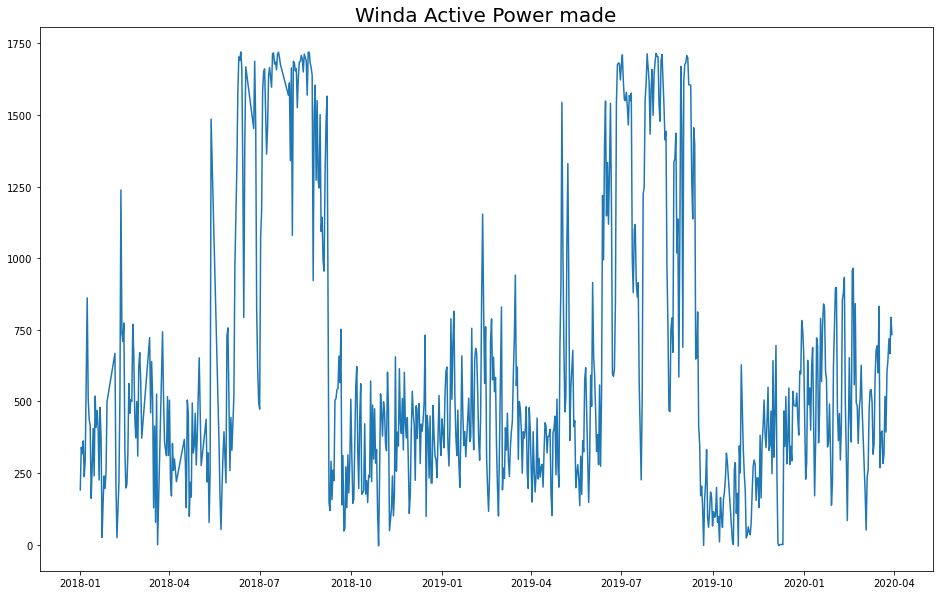

In [24]:
#Wizualizacja całego zbioru
Object.exploration_data(method='visualize')

In [25]:
#Podzielenie danych na zbiór treningowy, walidacyjny i testowy.
"""
Podzielenie danych jest jednym z ważniejszych kroków przy poprawnym testowaniu algorytmów. 
Zbiór testowy służy do nauki modelu i to na nim przeprowadzany będzie za każdym razem trening. 
Zbiór walidacyjny, ani żadne informacje z niego, nie są dostępne dla modelu podczas treningu. 
Dane walidacyjne służą do oceny działania algorytmu na poszczególnych hiperparametrach, które są różne zależnie od wybranego modelu. 
Kiedy najlepsze parametry zostaną wybrane (najlepsza metryka dla danych walidacyjnych), to model zostaje oceniony na zbiorze testowym, 
który służy do końcowej oceny. Można założyć, że model, który jednocześnie osiąga dobre rezultaty na danych walidacyjnych i testowych, 
będzie optymalnym algorytmem, który będzie potrafił uogólniać. 
"""
Object.split_data()

Zbiór treningowy od 2018-01-01 00:00:00 do 2019-05-29 00:00:00
Zbiór walidacyjny od 2019-05-30 00:00:00 do 2019-10-31 00:00:00
Zbiór testowy od 2019-11-01 00:00:00 do 2020-03-30 00:00:00



In [26]:
#Oceniam za pomocą metryki MAPE optymalne parametry dla modelu ARIMA. Argument 'how many' określa ile razy chcę uruchomić przeszukiwanie parametrów.
Object.hyperparameters_ARIMA(how_many = 10)

 MAPE: 1.7714894478739416 || Order = (2, 1, 5) || Seasonal order = (0, 1, 2, 24)
Czas treningu: 72.38673233985901s


 MAPE: 0.9987941269689774 || Order = (5, 1, 0) || Seasonal order = (0, 0, 2, 24)
Czas treningu: 2.9653220176696777s


 MAPE: 0.8926817709836178 || Order = (2, 0, 1) || Seasonal order = (0, 0, 1, 24)
Czas treningu: 2.245452404022217s


 MAPE: 1.3519354297833142 || Order = (0, 1, 0) || Seasonal order = (1, 0, 0, 24)
Czas treningu: 0.2031865119934082s


 MAPE: 0.9828519153148615 || Order = (1, 1, 2) || Seasonal order = (1, 0, 0, 24)
Czas treningu: 1.9282288551330566s


 MAPE: 1.8524389692104024 || Order = (1, 1, 0) || Seasonal order = (0, 1, 2, 24)
Czas treningu: 31.840998888015747s


 MAPE: 1.5721152479229614 || Order = (4, 1, 1) || Seasonal order = (1, 1, 1, 24)
Czas treningu: 15.190419673919678s


 MAPE: 0.8690483168472194 || Order = (3, 0, 4) || Seasonal order = (0, 0, 1, 24)
Czas treningu: 6.255807161331177s


 MAPE: 1.466265429282844 || Order = (1, 1, 4) || Seasonal o

In [27]:
#Oceniam za pomocą metryki MAPE optymalne parametry dla modelu Prophet. Argument 'how many' określa ile razy chcę uruchomić przeszukiwanie parametrów.
Object.hyperparameters_Prophet(how_many = 10)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


 MAPE: 0.5350107714274314 || Seasonality mode: additive || seasonality_prior_scale: 4.599919802318373 || alpha: 0.22328802579461676 
Czas treningu: 1.394888162612915s


 MAPE: 0.5327380884929895 || Seasonality mode: additive || seasonality_prior_scale: 7.968147451919124 || alpha: 0.3252440192383898 
Czas treningu: 0.17955827713012695s


 MAPE: 0.5332883124659434 || Seasonality mode: additive || seasonality_prior_scale: 2.934845806094734 || alpha: 0.2514749679472296 
Czas treningu: 0.21396660804748535s


 MAPE: 0.5331824324693039 || Seasonality mode: additive || seasonality_prior_scale: 18.756482909739653 || alpha: 0.6035063278595472 
Czas treningu: 0.15310454368591309s


 MAPE: 0.5541057923500937 || Seasonality mode: multiplicative || seasonality_prior_scale: 11.348877309871918 || alpha: 0.7079631712908744 
Czas treningu: 0.09973526000976562s


 MAPE: 0.5529445594477539 || Seasonality mode: multiplicative || seasonality_prior_scale: 16.719429358886565 || alpha: 0.2023060631693822 
Czas

In [28]:
#Ocena wybranych parametrów na zbiorze testowym

Object.test_on_test()

PROPHET: MAPE dla zbioru walidacyjnego wyniosło: 0.5323529864109356 z parametrami: seasonality_mode=additive | seasonality_prior_scale = 17.420807580673802 | alpha = 0.7575037981845494
 Test na zbiorze testowym:
 MAPE: 0.4812134194800861 || Seasonality mode: additive || seasonality_prior_scale: 17.420807580673802 || alpha: 0.7575037981845494 


ARIMA: MAPE dla zbioru walidacyjnego wyniosło: 0.8690483168472194 z parametrami: order = [3,0,4] | seasonal_order=[0,0,1]
 Test na zbiorze testowym:
 MAPE: 0.4575730828460985 || Order = (3, 0, 4) || Seasonal order = (0, 0, 1, 24)


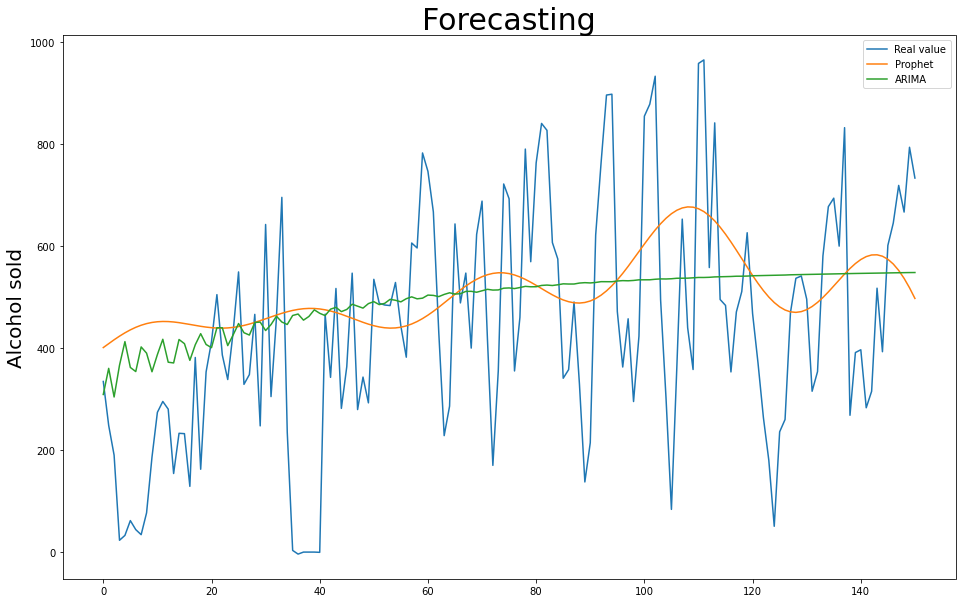

In [29]:
#Wyplotowanie wyników

Object.plot_results()

Ciężko jednoznacznie ocenić wyniki, gdyż każde kolejne uruchomienie algorytmu do przeszukiwania hiperparametrów może pogorszyć lub poprawić ostateczne prognozy. Mimo to po kilku uruchomieniach można zauważyć, że zarówno ARIMA jak i Prophet w miare poprawnie odczytują trend i sezonowość jednak nie radzą sobie z dokładnym odwzorowaniem pików. Może być tego kilka powodów:
- Zbyt mały zbiór danych uczących
- Dane uczące słabej jakości

Możliwymi usprawnieniami algorytmu mogłoby być:
- Dołożenie danych opisujących zmienną ActivePower (czyli zmienne, które w początkowej fazie projektu odrzuciliśmy)
- Zwiększenie zbioru uczącego
- Głębsze poszukiwanie hiperparametrów 